<a href="https://colab.research.google.com/github/YueWangpl/covid_pred/blob/main/src/EDA_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install plotly>=4.0.0
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4
# !pip install geopandas
# !pip install -U kaleido
# !pip install auto_ts --upgrade
# import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# Data cleaning and EDA

In [2]:
# with renewal:
df = pd.read_csv('https://query.data.world/s/sxvlqlsumzqr5sp33p5crszmdl36r4')

## or from folder 'data/' if downloaded:
# df = pd.read_csv('../data/COVID-19 Activity.csv')

df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



(2236500, 13)

In [2]:
# time series data
print(df.shape)
df.head()

(2232950, 13)


,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,0,Clarke,Alabama,2020-01-22,America,New York Times,0,1025.0,USA,United States,US,0,0
1,0,Clarke,Alabama,2020-01-23,America,New York Times,0,1025.0,USA,United States,US,0,0
2,0,Clarke,Alabama,2020-01-24,America,New York Times,0,1025.0,USA,United States,US,0,0
3,0,Clarke,Alabama,2020-01-25,America,New York Times,0,1025.0,USA,United States,US,0,0
4,0,Clarke,Alabama,2020-01-26,America,New York Times,0,1025.0,USA,United States,US,0,0


In [3]:
len(df['COUNTRY_ALPHA_3_CODE'].unique())

219

In [3]:
df[['DATA_SOURCE_NAME']].value_counts()

DATA_SOURCE_NAME          
New York Times                2063250
JHU CSSE Global Timeseries     173250
dtype: int64

In [8]:
len(df[df['DATA_SOURCE_NAME']=='New York Times']['COUNTY_NAME'].unique())

1930

In [73]:
sorted(df['REPORT_DATE'].unique())[-5:-1]

['2021-10-06', '2021-10-07', '2021-10-08', '2021-10-09']

Use data only in the US

In [9]:
df_us = df[df['COUNTRY_ALPHA_3_CODE']=="USA"]
df_us

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,0,Clay,Alabama,2020-01-22,America,New York Times,0,1027.0,USA,United States,US,0,0
1,0,Clay,Alabama,2020-01-23,America,New York Times,0,1027.0,USA,United States,US,0,0
2,0,Clay,Alabama,2020-01-24,America,New York Times,0,1027.0,USA,United States,US,0,0
3,0,Clay,Alabama,2020-01-25,America,New York Times,0,1027.0,USA,United States,US,0,0
4,0,Clay,Alabama,2020-01-26,America,New York Times,0,1027.0,USA,United States,US,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231213,10628,Madison,Tennessee,2021-04-11,America,New York Times,0,47113.0,USA,United States,US,0,240
2231214,1189,Madison,Tennessee,2020-08-11,America,New York Times,2,47113.0,USA,United States,US,29,20
2231215,1160,Madison,Tennessee,2020-08-10,America,New York Times,1,47113.0,USA,United States,US,58,18
2231216,636,Madison,Tennessee,2020-07-27,America,New York Times,0,47113.0,USA,United States,US,25,10


In [4]:
df_us['REPORT_DATE'] =  pd.to_datetime(df_us['REPORT_DATE'])
df_us.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PEOPLE_POSITIVE_CASES_COUNT                 int64
COUNTY_NAME                                object
PROVINCE_STATE_NAME                        object
REPORT_DATE                        datetime64[ns]
CONTINENT_NAME                             object
DATA_SOURCE_NAME                           object
PEOPLE_DEATH_NEW_COUNT                      int64
COUNTY_FIPS_NUMBER                        float64
COUNTRY_ALPHA_3_CODE                       object
COUNTRY_SHORT_NAME                         object
COUNTRY_ALPHA_2_CODE                       object
PEOPLE_POSITIVE_NEW_CASES_COUNT             int64
PEOPLE_DEATH_COUNT                          int64
dtype: object

In [10]:
df_us['PEOPLE_POSITIVE_NEW_CASES_COUNT'].describe()

count    2.008440e+06
mean     2.201349e+01
std      2.821782e+02
min     -1.239550e+05
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+01
max      5.661000e+04
Name: PEOPLE_POSITIVE_NEW_CASES_COUNT, dtype: float64

In [5]:
df_USdaily = df_us[['REPORT_DATE','PEOPLE_POSITIVE_NEW_CASES_COUNT']].groupby(by='REPORT_DATE').agg('sum').reset_index()
df_USdaily

,REPORT_DATE,PEOPLE_POSITIVE_NEW_CASES_COUNT
0,2020-01-21,1
1,2020-01-22,0
2,2020-01-23,0
3,2020-01-24,1
4,2020-01-25,1
...,...,...
625,2021-10-07,104989
626,2021-10-08,112628
627,2021-10-09,37200
628,2021-10-10,23025


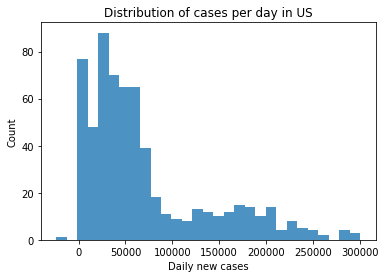

In [92]:
df_USdaily['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot.hist(bins = int(np.sqrt(df_us.shape[0])/48), alpha=0.8)  
plt.ylabel('Count')
# plt.semilogx()
plt.xlabel('Daily new cases')
plt.title('Distribution of cases per day in US')
plt.savefig('../figures/USdailyhist.png')
plt.show()

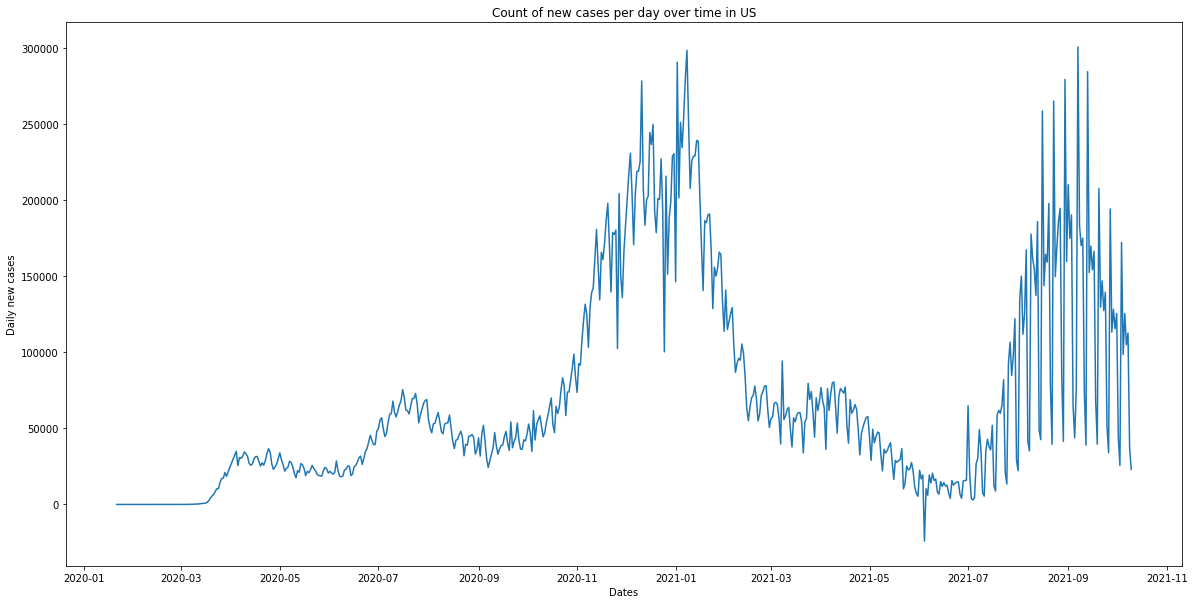

In [93]:
plt.figure(figsize=(20, 10))
plt.plot(df_USdaily['REPORT_DATE'], df_USdaily['PEOPLE_POSITIVE_NEW_CASES_COUNT'])  
plt.ylabel('Daily new cases')
# plt.semilogx()
plt.xlabel('Dates')
plt.title('Count of new cases per day over time in US')
plt.savefig('../figures/USdailyCountvsTime.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



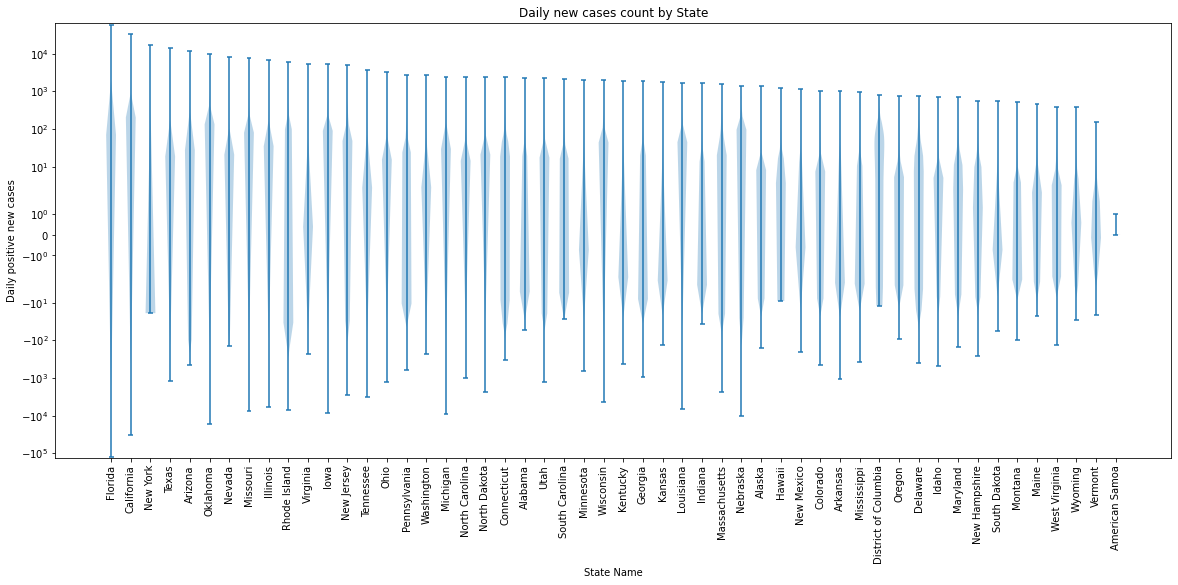

In [66]:
categories = df_us.groupby(['PROVINCE_STATE_NAME'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].agg('max').reset_index().sort_values(by=['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ascending=False)['PROVINCE_STATE_NAME'].unique()

dataset = [df_us[df_us['PROVINCE_STATE_NAME']==i]['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values for i in categories]

plt.figure(figsize=(20, 8))
plt.violinplot(dataset = dataset)
plt.xticks([i+1 for i in range(len(categories))],categories, rotation = 90)
plt.ylabel('Daily positive new cases')
# plt.semilogy()
plt.yscale('symlog')
plt.xlabel('State Name')
plt.title('Daily new cases count by State')
plt.savefig('../figures/states-violin.png')
plt.show()

In [36]:
# https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [100]:
df_StateCases = df_us.groupby(['PROVINCE_STATE_NAME'])['PEOPLE_POSITIVE_CASES_COUNT'].agg('max').reset_index()

fig = go.Figure(data=go.Choropleth(
    locations=[us_state_to_abbrev[x] for x in df_StateCases['PROVINCE_STATE_NAME']], # Spatial coordinates
    z = df_StateCases['PEOPLE_POSITIVE_CASES_COUNT'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Counts",
))

fig.update_layout(
    title_text = 'State Max Total COVID-19 Positive Cases',
    geo_scope='usa', # limite map scope to USA
)

fig.write_image("../figures/stateMax.png")
fig.show()

In [117]:
df_StateCases = df_us.groupby(['PROVINCE_STATE_NAME'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].agg('mean').reset_index()

fig = go.Figure(data=go.Choropleth(
    locations=[us_state_to_abbrev[x] for x in df_StateCases['PROVINCE_STATE_NAME']], # Spatial coordinates
    z = df_StateCases['PEOPLE_POSITIVE_NEW_CASES_COUNT'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Counts",
))

fig.update_layout(
    title_text = 'State Mean Daily COVID-19 Positive Cases',
    geo_scope='usa', # limite map scope to USA
)

fig.write_image("../figures/dailyStateMean.png")
fig.show()

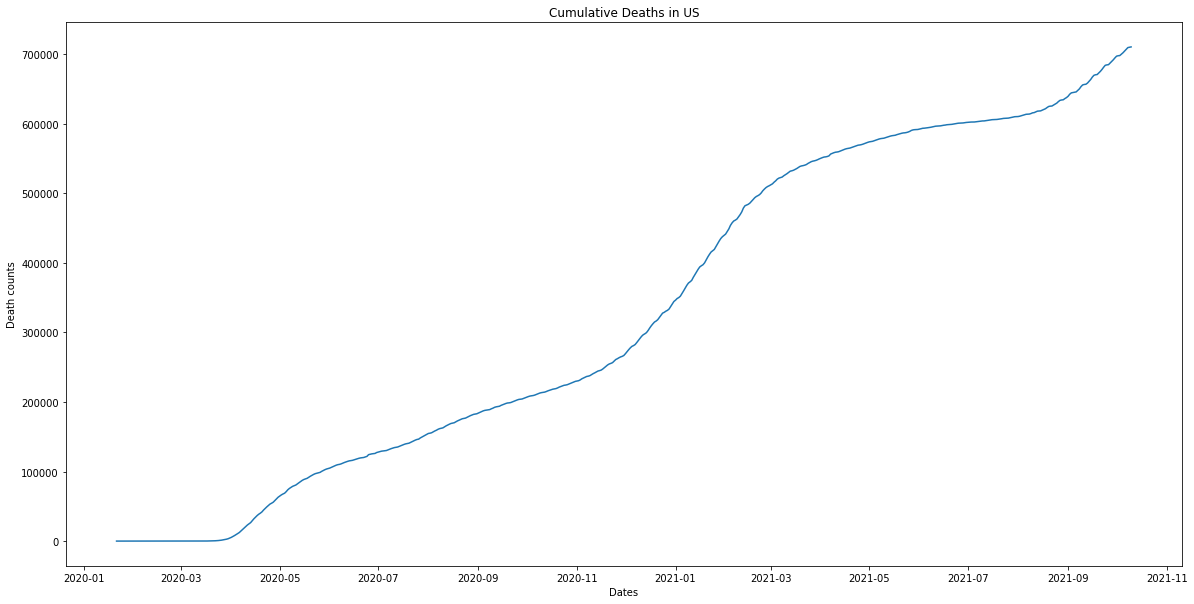

In [113]:
df2 = df_us[['REPORT_DATE','PEOPLE_DEATH_COUNT']].groupby(by='REPORT_DATE').agg('sum').reset_index()

plt.figure(figsize=(20, 10))
plt.plot(df2['REPORT_DATE'], df2['PEOPLE_DEATH_COUNT'])  
plt.ylabel('Death counts')
# plt.semilogx()
plt.xlabel('Dates')
plt.title('Cumulative Deaths in US')
plt.savefig('../figures/USdeaths.png')
plt.show()

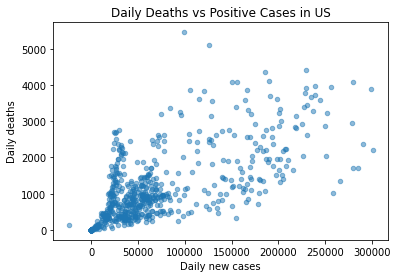

In [118]:
df2 = df_us[['REPORT_DATE','PEOPLE_POSITIVE_NEW_CASES_COUNT', 'PEOPLE_DEATH_NEW_COUNT']].groupby(by='REPORT_DATE').agg('sum').reset_index()
df2[['PEOPLE_POSITIVE_NEW_CASES_COUNT','PEOPLE_DEATH_NEW_COUNT']].plot.scatter('PEOPLE_POSITIVE_NEW_CASES_COUNT','PEOPLE_DEATH_NEW_COUNT', alpha=0.5)
plt.xlabel('Daily new cases')
plt.ylabel('Daily deaths')
plt.title('Daily Deaths vs Positive Cases in US')
plt.savefig('../figures/USDeathsvCases.png')
plt.show()

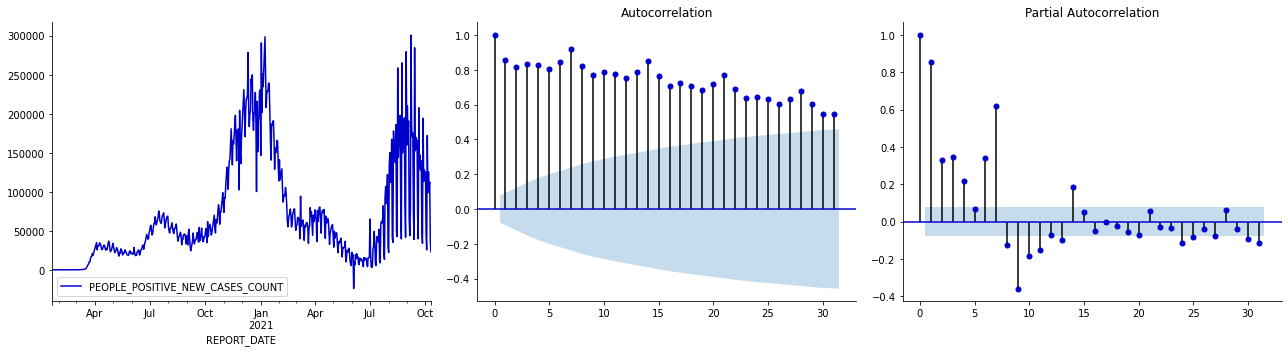

In [125]:
# https://github.com/mollyliebeskind/sales_forecasting/
import statsmodels.tsa.api as smt

def plots(data, indcol = 'REPORT_DATE', lags=None):
    
  # Convert dataframe to datetime index
  dt_data = data.set_index(indcol)
  
  layout = (1, 3)
  raw  = plt.subplot2grid(layout, (0, 0))
  acf  = plt.subplot2grid(layout, (0, 1))
  pacf = plt.subplot2grid(layout, (0, 2))
  
  dt_data.plot(ax=raw, figsize=(18, 5), color='mediumblue')
  smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
  smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
  sns.despine()
  plt.savefig('../figures/autocorr.png')
  plt.tight_layout()

plots(df_USdaily, lags=31);

# Preprocessing

In [60]:
# sklearn.model_selection.TimeSeriesSplit

def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag, 31 lags
    for i in range(1,31):
        col = 'lag_' + str(i)
        supervised_df[col] = supervised_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    # supervised_df.to_csv('../data/model_df.csv', index=False)
    
    return supervised_df
model_df = generate_supervised(df_USdaily)
model_df

,REPORT_DATE,PEOPLE_POSITIVE_NEW_CASES_COUNT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
0,2020-02-20,2,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0
1,2020-02-21,3,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
2,2020-02-22,0,3.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
3,2020-02-23,0,0.0,3.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
4,2020-02-24,13,0.0,0.0,3.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2021-10-07,104989,125441.0,98530.0,172232.0,25627.0,44057.0,125475.0,115496.0,128201.0,113295.0,194221.0,33991.0,51254.0,139561.0,127443.0,147036.0,129693.0,207620.0,39653.0,67843.0,166451.0,154285.0,169868.0,152417.0,284477.0,38944.0,73494.0,175104.0,170208.0,183470.0,300769.0
596,2021-10-08,112628,104989.0,125441.0,98530.0,172232.0,25627.0,44057.0,125475.0,115496.0,128201.0,113295.0,194221.0,33991.0,51254.0,139561.0,127443.0,147036.0,129693.0,207620.0,39653.0,67843.0,166451.0,154285.0,169868.0,152417.0,284477.0,38944.0,73494.0,175104.0,170208.0,183470.0
597,2021-10-09,37200,112628.0,104989.0,125441.0,98530.0,172232.0,25627.0,44057.0,125475.0,115496.0,128201.0,113295.0,194221.0,33991.0,51254.0,139561.0,127443.0,147036.0,129693.0,207620.0,39653.0,67843.0,166451.0,154285.0,169868.0,152417.0,284477.0,38944.0,73494.0,175104.0,170208.0
598,2021-10-10,23025,37200.0,112628.0,104989.0,125441.0,98530.0,172232.0,25627.0,44057.0,125475.0,115496.0,128201.0,113295.0,194221.0,33991.0,51254.0,139561.0,127443.0,147036.0,129693.0,207620.0,39653.0,67843.0,166451.0,154285.0,169868.0,152417.0,284477.0,38944.0,73494.0,175104.0


In [ ]:
# datetime_df = df_USdaily.set_index('REPORT_DATE')

In [ ]:
# !pip install auto_ts --upgrade

In [52]:
from sklearn.model_selection import train_test_split

def basic_split(X, y, train_size = 0.6, val_size = 0.2, test_size = 0.2, random_seed = 42):
    if type(random_seed)!= int:
        raise ValueError("Random_seed should be an integer.")
    if (train_size+val_size+test_size) != 1:
        raise ValueError("The sum of train_size, val_size, test_size should be 1.")

    random_state = random_seed
    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = train_size,random_state=random_state)
    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = (val_size/(1-train_size)),random_state=random_state)
    
    allsize = X.shape[0]
    if ((round(X_train.shape[0]/allsize, 1) != 0.6) or 
        (round(X_val.shape[0]/allsize, 1) != 0.2) or 
        (round(X_test.shape[0]/allsize, 1) != 0.2)):
        raise ValueError("Data not split into desired size.")

    return X_train, y_train, X_val, y_val, X_test, y_test

# let's separate the feature matrix X, and target variable y
X = model_df.iloc[:, 2:]
y = model_df['PEOPLE_POSITIVE_NEW_CASES_COUNT']
X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X, y, train_size = 0.6, val_size = 0.2, test_size = 0.2, random_seed = 42)
print(X_train.head())
print(X_val.head())
print(X_test.head())

        lag_1     lag_2     lag_3  ...   lag_28    lag_29    lag_30
569  175104.0  170208.0  183470.0  ...  48824.0  185919.0  137397.0
381   56322.0   65486.0   67169.0  ...  86774.0  104649.0  129398.0
411   76123.0   36188.0   63340.0  ...  55778.0   94294.0   39759.0
154   69610.0   64789.0   59475.0  ...  41101.0   36846.0   34934.0
126   36846.0   34934.0   30427.0  ...  22422.0   18670.0   18828.0

[5 rows x 30 columns]
       lag_1     lag_2     lag_3     lag_4  ...   lag_27   lag_28   lag_29   lag_30
132  48164.0   39425.0   39385.0   42155.0  ...  21127.0  19897.0  20726.0  21800.0
15      67.0      36.0      21.0      16.0  ...      0.0      0.0      0.0      1.0
176  53596.0   53592.0   52696.0   46437.0  ...  62103.0  70357.0  75476.0  68079.0
535  41642.0  167259.0  125621.0  111908.0  ...  35193.0   5457.0   7647.0  35215.0
494   4040.0    6753.0   14821.0   14668.0  ...  22463.0   5392.0   7348.0  11430.0

[5 rows x 30 columns]
        lag_1     lag_2     lag_3  ...    

In [68]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_val_ss = scaler.transform(X_val)
X_test_ss = scaler.transform(X_test)

# Regression models tried on dataset

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [70]:

mod = LinearRegression()
mod.fit(X_train_ss, y_train)
pred = mod.predict(X_test_ss)
len(pred)
# # df_pred = df_USdaily.copy()
# df_pred = df_USdaily.iloc[300:]
# df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-21)), pred)
# df_pred

21

In [72]:
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

MSE: 1480374738.4465058
MAE: 30149.90652270143
R2 Score: 0.34887757178796863


In [67]:
from sklearn.model_selection import TimeSeriesSplit

X = model_df.iloc[:, 2:]
y = model_df['PEOPLE_POSITIVE_NEW_CASES_COUNT']

tscv = TimeSeriesSplit(n_splits=2, test_size=21)  # test on 21 days of data
for train_index, test_index in tscv.split(X):
  pass
print(len(train_index), len(test_index))
# print("TRAIN:", train_index, "TEST:", test_index)
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
# X_val_ss = scaler.transform(X_val)
X_test_ss = scaler.transform(X_test)

# transform target?

579 21


In [45]:
mod = LinearRegression()
mod.fit(X_train_ss, y_train)
pred = mod.predict(X_test_ss)
len(pred)

21

In [46]:
# df_pred = df_USdaily.copy()
df_pred = df_USdaily.iloc[300:]
df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-21)), pred)
df_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,REPORT_DATE,PEOPLE_POSITIVE_NEW_CASES_COUNT,pred
300,2020-11-16,165773,NaN
301,2020-11-17,160986,NaN
302,2020-11-18,171830,NaN
303,2020-11-19,186911,NaN
304,2020-11-20,197906,NaN
...,...,...,...
625,2021-10-07,104989,76308.292198
626,2021-10-08,112628,101436.586677
627,2021-10-09,37200,27679.177397
628,2021-10-10,23025,-4367.958027


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



MSE: 1480374738.4465077
R2 Score: 0.34887757178796774


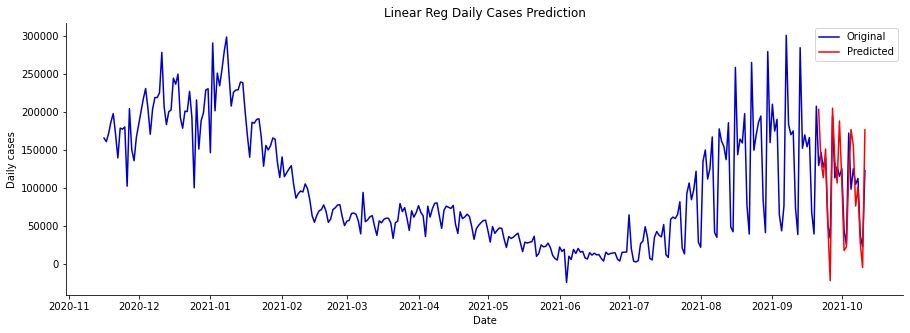

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="Linear Reg Daily Cases Prediction")
ax.legend()
sns.despine()

mse = mean_squared_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-21:], df_pred.pred[-21:])
mae = mean_absolute_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-21:], df_pred.pred[-21:])
r2 = r2_score(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-21:], df_pred.pred[-21:])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.savefig('LinRegPred.png')

Without scaling on X:

MSE: 1480374738.4465077 R2 Score: 0.34887757178796774

With scaling on X:

MSE: 1480374738.4465058 R2 Score: 0.34887757178796863



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



MSE: 1480374738.4465058
R2 Score: 0.34887757178796863


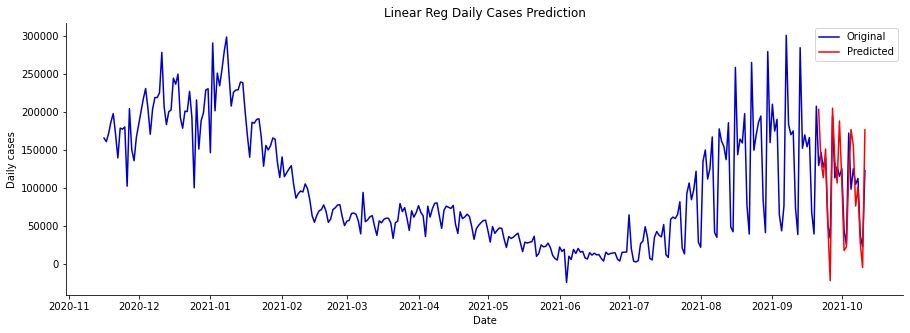

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="Linear Reg Daily Cases Prediction")
ax.legend()
sns.despine()

mse = mean_squared_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-21:], df_pred.pred[-21:])
mae = mean_absolute_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-21:], df_pred.pred[-21:])
r2 = r2_score(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-21:], df_pred.pred[-21:])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.savefig('LinRegPred.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



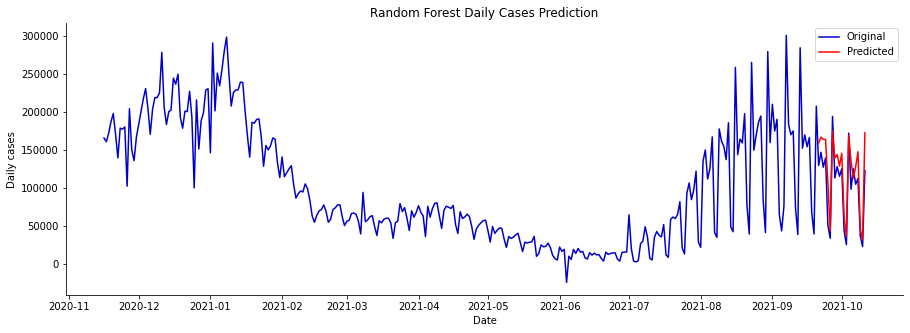

In [48]:
mod = RandomForestRegressor(n_estimators=100, max_depth=20)
mod.fit(X_train, y_train)
pred = mod.predict(X_test)
df_pred = df_USdaily.iloc[300:]
df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-21)), pred)
df_pred
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="Random Forest Daily Cases Prediction")
ax.legend()
sns.despine()

plt.savefig('../figures/RandForestPred.png')

[17:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



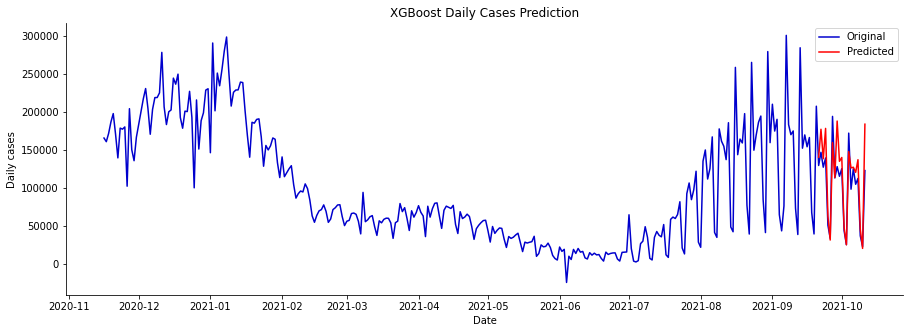

In [50]:
mod = XGBRegressor(n_estimators=100, learning_rate=0.2)
mod.fit(X_train, y_train)
pred = mod.predict(X_test)
df_pred = df_USdaily.iloc[300:]
df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-21)), pred)
df_pred
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="XGBoost Daily Cases Prediction")
ax.legend()
sns.despine()

# plt.savefig('../figures/XGBPred.png')

ideas:
neighbor counties (check lat+longt)
+
use lastday count, last 2 days count, ... as features to do prediction

[time series sklearn](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py)  
[ewma](https://stackoverflow.com/questions/20841167/how-to-predict-time-series-in-scikit-learn)  
[RandomForestRegressor()](https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1)  
[statsmodels.tsa](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)